# <center>Digital Image Processing - Problem Set 5</center>

### Student Names:
Jorge Ortega, Sebastian Salas, Katerine Vera

['three_bottles', 'new_bottles', 'hubble-original', 'bottles', 'face', 'shapes'] 

['image_0001', 'image_0002', 'image_0003', 'image_0004', 'image_0005', 'image_0006', 'image_0007', 'image_0008', 'image_0009', 'image_0010', 'image_0011', 'image_0012', 'image_0013', 'image_0014', 'image_0015', 'image_0016', 'image_0017', 'image_0018', 'image_0019', 'image_0020'] 



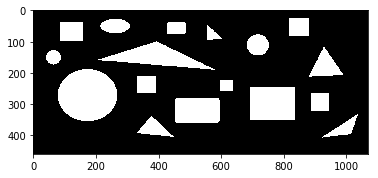

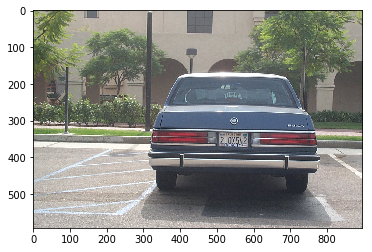

In [367]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import listdir, path
%matplotlib inline

pathCars = "cars"
pathImages = "img"

imgKeys   = []
carKeys   = []

files = {
    "car" :{ },
    "img":{ }
}

FilesImg = listdir("img")
FilesCars = listdir("cars")

FilesCars.sort(key=lambda x: int(''.join(filter(str.isdigit, x.split("_")[1].split(".")[0]))))

for i in FilesImg:
    key = i.split(".")[0]
    if key != "":
        imgKeys.append(key)
        files["img"][key] = cv2.imread(pathImages + "/" + i, cv2.IMREAD_GRAYSCALE)
        
for i in FilesCars:
    key = i.split(".")[0]
    if key != "":
        carKeys.append(key)
        temp = cv2.imread(pathCars + "/" + i, cv2.IMREAD_COLOR)
        files["car"][key] = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)


# Clean Up
FilesImg   = None
FilesCars  = None
pathCars   = None
pathImages = None

print(imgKeys , "\n")
print(carKeys, "\n")

# Test
plt.imshow(files["img"]["shapes"], cmap="gray")
plt.show()

plt.imshow(files["car"][carKeys[0]])
plt.show()


### Problem 1

Write a function that describes <i>each</i> object in a binary image using the Hu statistical moments. The Hu moments are invariant to rotation, scale and translation. These moments can be defined for <i>each</i> region in a binary image. The OpenCV function to compute these moments is <tt>cv2.HuMoments</tt>.

In [ ]:
# Cate con K

### Problem 2

Write a function that detects corners on an image using the Harris corner detection method. You can use the OpenCV built-in functions. Your function should output the $N$ detected corner locations in a $2 \times N$ matrix. Visualize your results by plotting the corners on top of the input image.  Apply your function to the binary image <tt> shapes.png</tt> and to the grayscale image <tt>face.tif</tt>.

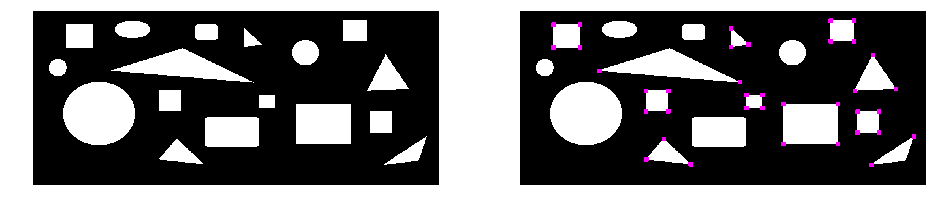

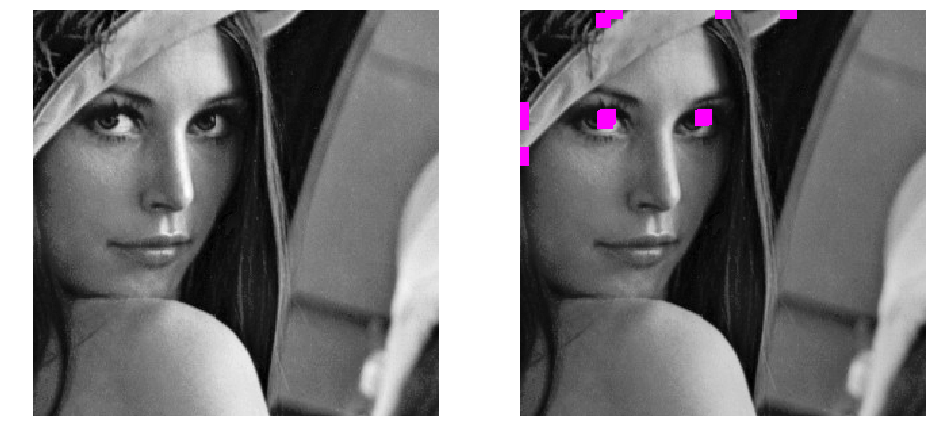

In [293]:
img = [files["img"]["shapes"].copy(), files["img"]["face"].copy()]


def cornerDetector(img,th):
    dst = cv2.cornerHarris(np.float32(img),2,3,0.04)

    cv2.normalize(dst, dst, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)
    dst = cv2.dilate(dst,None)
    
    kernel = np.ones((9, 9), np.uint8)
    dst = cv2.dilate(dst, kernel, iterations=1)
    cv2.normalize(dst, dst, 0, 255, cv2.NORM_MINMAX, cv2.CV_32FC1)
    dst = np.uint8(dst)

    mask = np.uint8((dst>th))
    
    nmask = np.uint8((dst<th))
    dst = dst*mask

    r = mask*255
    g = mask*0
    b = mask*255

    dst = cv2.merge([r,g,b])
    nmaskrgb = cv2.cvtColor( nmask, cv2.COLOR_GRAY2RGB)
    
    rgbColor = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    return (rgbColor*nmaskrgb)+dst


for i in img:
    plt.figure(figsize=(16,16))
    plt.subplot(1,2,1)
    plt.imshow(i, cmap="gray")
    plt.axis("off")
    
    x = cornerDetector(i,50)
    
    plt.subplot(1,2,2)
    plt.imshow(x)
    plt.axis("off")
    plt.show()

# Clean Up
img = None

### Problem 3

A company that bottles a variety of industrial chemicals has heard
of your success solving imaging problems and hires you to design an approach
for detecting when bottles are not full. The bottles appear as shown below
as they move along a conveyor line past an automatic
filling and capping station. A bottle is considered imperfectly filled when the
level of the liquid is below the midway point between the bottom of the neck and
the shoulder of the bottle.The shoulder is defined as the region of the bottle
where the sides and slanted portion of the bottle intersect. The bottles are
moving, but the company has an imaging system equipped with an illumination
flash front end that effectively stops motion, so you will be given images that
look very close to the sample shown below.

<img src="files/bottles.png" />

Propose a solution for detecting
bottles that are not filled properly. State clearly all assumptions that you
make and that are likely to impact the solution you propose. Implement your
solution and apply it to the images <tt>bottles.tif, new_bottles.jpg</tt> and <tt> three_bottles.jpg</tt>. Visualize the results
of your algorithm by highlighting with false colors
the regions that are detected as correctly
filled bottles and the regions that are detected as not properly filled bottles.

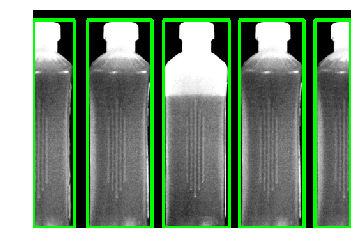

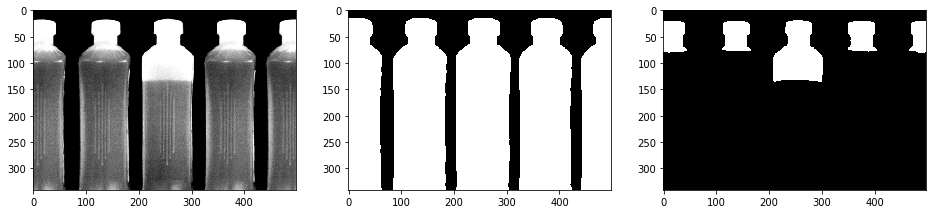

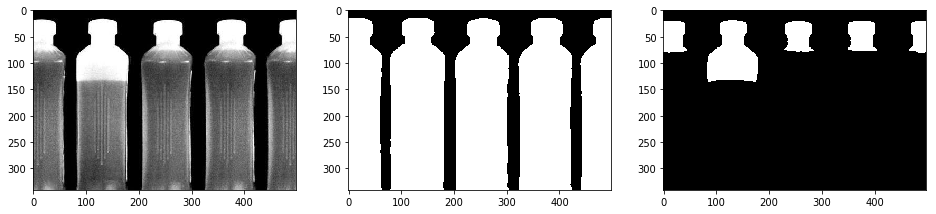

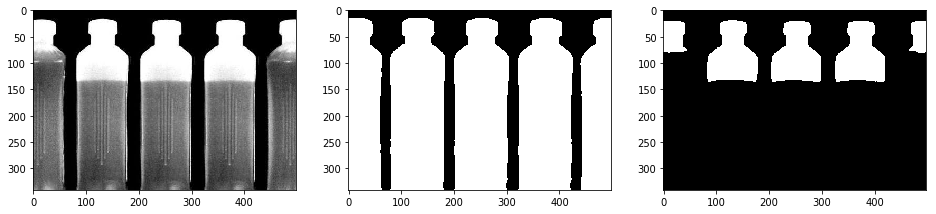

In [423]:
# Utils #######################################################

Color = {
    "Good": (   0, 255,   0),
    "Bad" : ( 255,   0,   0)
}

def blur(img, kernel):
    return cv2.blur(img, (kernel, kernel))

def thresh(img, th):
    _, ret = cv2.threshold(img, th, 255, cv2.THRESH_BINARY)
    return ret

def adapt(img, kernel, th):
    res = img.copy()
    res = blur(res, kernel)
    res = thresh(res, th)
    return res

def rect(img, data, color):
    x1, y1, x2, y2 = data
    return cv2.rectangle(img, (x1,y1), (x2, y2), color, 3)

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gray2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def getContours(img):
    _, contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

###############################################################

img = [
    files["img"]["bottles"].copy(), 
    files["img"]["new_bottles"].copy(), 
    files["img"]["three_bottles"].copy()
]


test = img[0].copy()
drawer = gray2rgb(test)

h,w = test.shape



adaptedImg = adapt(test, 6, 10)

contours = getContours(adaptedImg)

for c in contours:
    mins_x, mins_y = list(), list()
    maxs_x, maxs_y = list(), list()

    cor_x, cor_y = list(), list()

    for cnt in c:
        cor_x.append(cnt[0][0])
        cor_y.append(cnt[0][1])


    drawer = rect(drawer, (min(cor_x) ,min(cor_y) ,max(cor_x) ,max(cor_y)), Color["Good"])



plt.imshow(drawer)
plt.axis("off")
plt.show()



# ploter

for i in range(len(img)):
    plt.figure(figsize=(16,16))
    
    temp = img[i].copy()
    
    plt.subplot(1, 3, 1)
    plt.imshow(temp, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.imshow(adapt(temp, 6, 10), cmap="gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(adapt(temp, 6, 200), cmap="gray")
    
    plt.show()



# Clean Up
img    = None
temp   = None
test   = None
drawer = None

### Problem 4

Suppose that you are observing objects in the night sky. Suppose that only ‘big’ objects are important to your observation. In this scenario, ‘small’ objects are considered noise. Write a python function that processes the image as follows:

1. Use a 15x15 averaging filter to blur the image.

2. Apply a threshold of 0.25 to binarize the resulting blurred image.

3. Use the binary image to ‘mask’ the noise of the original image: simply perform an element-wise multiplication of the binary image and the original image.

4. Use connected component analysis on the binary image to count the number of ‘big’ objects found.

The function should take three inputs: an image matrix, the size of the averaging filter and threshold value. Make sure your function displays the intermediary results of each step outlined above.

Apply your function to the input image ‘hubble-original.tif’. Try different values of smoothing kernel size and threshold value. Analyze the relationship between number of objects found and smoothing kernel size and threshold value. In particular, you might want to observe the result when using an averaging filter of size n=1 (i.e. no smoothing).

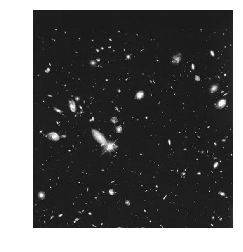

In [69]:
img = files["img"]["hubble-original"].copy()
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Clean Up
img=None

### Problem 5

Write a Python function that computes the bag-of-features representation of an image. In order to accomplish this, your function will need to perform the following steps:

1. Load the input image and apply the SIFT transform to obtain descriptors from its interest points. 
2. Group descriptors: Your function should use the k-means clustering algorithm to group all input features into k=100 groups.
3. Compute a histogram that counts how many times each codebook entry is selected as the closest center.

Apply your function to all car images <tt>image_00XX.jpg</tt>. Store the result in a data file.


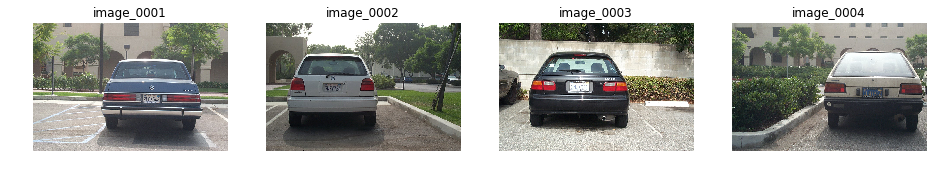

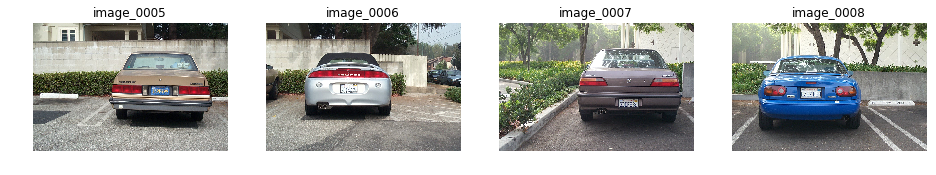

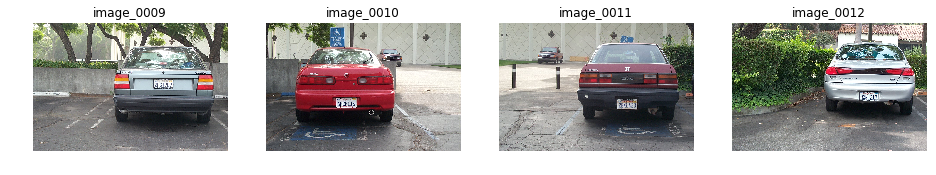

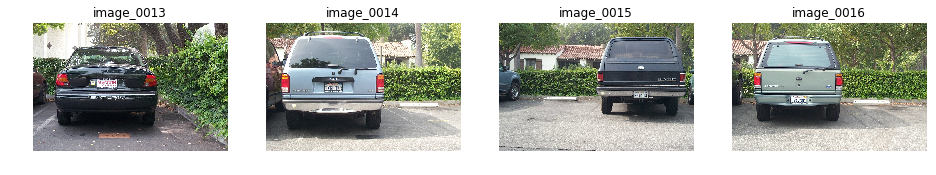

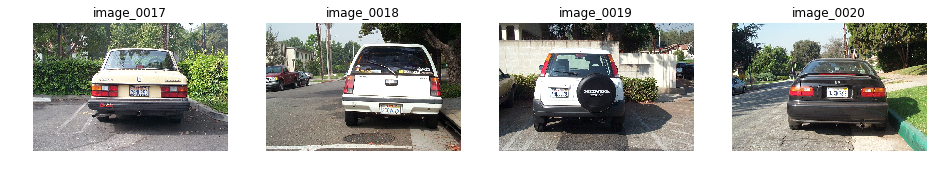

In [88]:
img = files["car"].copy()

# Test
j = 1
for i in carKeys:
    if j==1:
        plt.figure(figsize=(16,16))
    plt.subplot(1,4,j)
    plt.imshow(img[i])
    plt.title(i)
    plt.axis("off")
    if j<4:
        j = j+1
    else:
        plt.show()
        j=1

# Clean Up
img=None
j=None